# 2D image transformation demo

This demo shows how to apply 2D transforms in MONAI.
Main features:
    - Random elastic transforms implemented in native Pytorch
    - Easy-to-use interfaces that are designed and implemented in the pythonic way
    
Find out more in MONAI's wiki page: https://github.com/Project-MONAI/MONAI/wiki

## Before running this demo
**please download the GLAS (gland segmentation in histology images) challenge data from:**
https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/

The dataset used in this competition is provided for research purposes only. Commercial uses are not allowed.

If you intend to publish research work that uses this dataset, you must cite our review paper to be published after the competition

K. Sirinukunwattana, J. P. W. Pluim, H. Chen, X Qi, P. Heng, Y. Guo, L. Wang, B. J. Matuszewski, E. Bruni, U. Sanchez, A. Böhm, O. Ronneberger, B. Ben Cheikh, D. Racoceanu, P. Kainz, M. Pfeiffer, M. Urschler, D. R. J. Snead, N. M. Rajpoot, "Gland Segmentation in Colon Histology Images: The GlaS Challenge Contest" http://arxiv.org/abs/1603.00275 [Preprint]

`wget https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip`

`unzip warwick_qu_dataset_released_2016_07_08.zip`

In [2]:
%matplotlib inline

import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import monai
from monai.transforms import Affine, Rand2DElastic

monai.config.print_config()

MONAI version: 0.0.1
Python version: 3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:30:03)  [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.18.2
Pytorch version: 1.4.0
Ignite version: 0.3.0


In [3]:
img_name = './Warwick QU Dataset (Released 2016_07_08)/train_22.bmp'
seg_name = './Warwick QU Dataset (Released 2016_07_08)/train_22_anno.bmp'
im = np.array(Image.open(img_name))
seg = np.array(Image.open(seg_name))

(522, 775, 3) (522, 775)


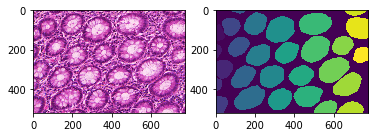

In [4]:
f, axes = plt.subplots(1,2)
axes[0].imshow(im)
axes[1].imshow(seg)
print(im.shape, seg.shape)

### Affine transformation

In [6]:
from monai.transforms import Affine

# MONAI transforms always take channel-first data: [channel x H x W]
im_data = np.moveaxis(im, -1, 0)  # make them channel first
seg_data = np.expand_dims(seg, 0)  # make a channel for the segmentation

# create an Affine transform
affine = Affine(rotate_params=np.pi/4, scale_params=(1.2, 1.2), translate_params=(200, 40), 
                padding_mode='zeros', device=torch.device('cuda:0'))
# convert both image and segmentation using different interpolation mode
new_img = affine(im_data, (300, 400), mode='bilinear')
new_seg = affine(seg_data, (300, 400), mode='nearest')
print(new_img.shape, new_seg.shape)

(3, 300, 400) (1, 300, 400)


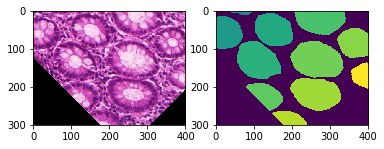

In [7]:
f, axes = plt.subplots(1,2)
axes[0].imshow(np.moveaxis(new_img.astype(int), 0, -1))
axes[1].imshow(new_seg[0].astype(int))

### Elastic deformation

In [10]:
from monai.transforms import Rand2DElastic

# create an elsatic deformation transform
deform = Rand2DElastic(prob=1.0, spacing=(30, 30), magnitude_range=(5, 6),
                       rotate_range=(np.pi/4,), scale_range=(0.2, 0.2), translate_range=(100, 100), 
                       padding_mode='zeros', device=torch.device('cuda:0'))
# transform both image and segmentation using different interpolation mode
deform.set_random_state(seed=123)
new_img = deform(im_data, (224, 224), mode='bilinear')
deform.set_random_state(seed=123)
new_seg = deform(seg_data, (224, 224), mode='nearest')
print(new_img.shape, new_seg.shape)

(3, 224, 224) (1, 224, 224)


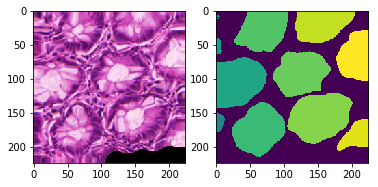

In [11]:
f, axes = plt.subplots(1,2)
axes[0].imshow(np.moveaxis(new_img.astype(int), 0, -1))
axes[1].imshow(new_seg[0].astype(int))